# Inference
The topic of this notebook is to prototype the creation of an inference pipeline that will serve as a guideline for the actual system to be implemented.

## Plan
1. Go through a single scene of the FDST images.
2. Define and extract zones of interest.
3. Warp the perspective of a single image to 4 different images (3 warped, 1 original).
4. Use the model to get the count of people in each segment of the image, as well as each perspective.
5. Average the number of the predicted count for each zone of interest.

## Motivation
Since in the original idea 4 cameras are going to be used to count the people in one hall the goal is to simulate that by wapring the perspective of each image. Before hand some zones of interest need to be defined (3 to begin with). Then for each defined zone average the infered count.

## Imports and Globals

In [1]:
import os
import sys
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
from models.definitions.csr import CSRNet
from models.definitions.dsnet import DenseScaleNet

In [3]:
BEST_MODEL_SAVE_PATH = 'models/best/'
CKP_MODEL_SAVE_PATH = 'models/checkpoints/'
FDST_TEST_IMAGES = 'training_dataset/fdst/test_data/90/'
EXAMPLE_IMAGE_JPG = os.path.join(FDST_TEST_IMAGES, '001.jpg')
EXAMPLE_IMAGE_JSON = os.path.join(FDST_TEST_IMAGES, '001.json')

### Utilities
Some functions that provide various utilities and helper functions.

In [4]:
def load_pretrained_model(model_filepath):
    '''
        Load the model from the filepath
    '''
    state = torch.load(checkpoint_filepath)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    epoch = state['epoch']
    return epoch, model, optimizer

In [5]:
def show_image(img, plot_area=(15, 10)):
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(img)   

def show_image_from_path(path, plot_area=(15, 10)):
    image = cv2.imread(path)
    show_image(image, plot_area)

In [56]:
def fill_zone(img, points, color):
    points = np.array(points)
    return cv2.fillPoly(img, pts=[points], color=color)

In [64]:
def blend_images(raw_img, updated_img, opacity):
    return cv2.addWeighted(raw_img, 1-opacity, updated_img, opacity, 0)

In [83]:
def extract_zone_image(img, zone):
    stencil = np.zeros(img.shape).astype(img.dtype)
    stencil = fill_zone(stencil, [zone], [255, 255, 255])
    return cv2.bitwise_and(img, stencil)

## Plan Execution

### 1. Go through a single scene from FDST
What 'going-through' means a single image from the FDST dataset will be explored and analyzed for the purpose of the inference.

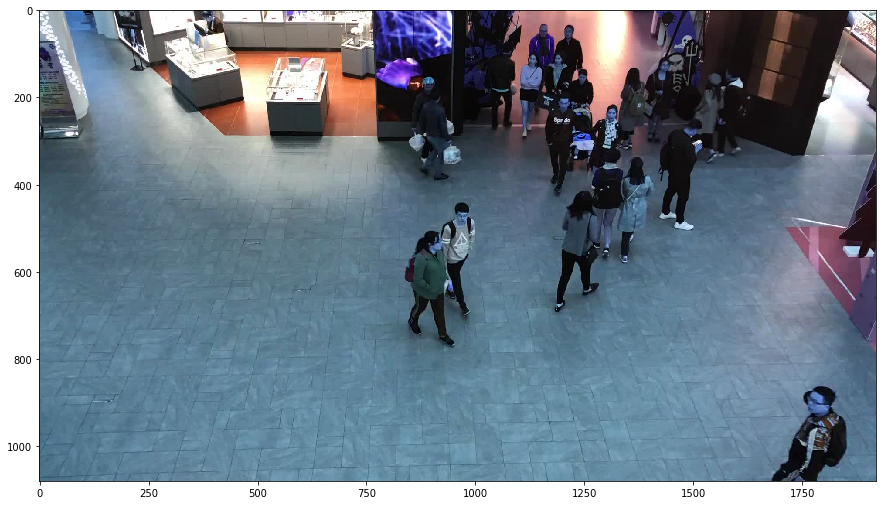

In [57]:
show_image_from_path(EXAMPLE_IMAGE_JPG)

As the example shows the image is suitable for analysis and perspective distortion as this is the sort of images we expect from the real scenario.

### 2. Define and extract the zones of interest
As stated above the goal is to have 3 zones of interest defined, on which to have perform inference.

In [72]:
# example_zone = [low_left, low_right, up_right, up_left]
# zone_one = [(1050, 750), (1850, 750), (1000, 45), (1650, 55)]
# zone_two = [(100, 750), (1000, 750), (120, 40), (950, 45)]
# zone_three = [(100, 1050), (1850, 1050), (80, 810), (1850, 810)]
zone_one = [(1050, 750), (1850, 750), (1650, 30), (1000, 25)]
zone_two = [(100, 750), (1010, 750), (980, 45), (120, 40)]
zone_three = [(100, 1050), (1850, 1050), (1850, 810), (80, 810)]
zones = [zone_one, zone_two, zone_three]

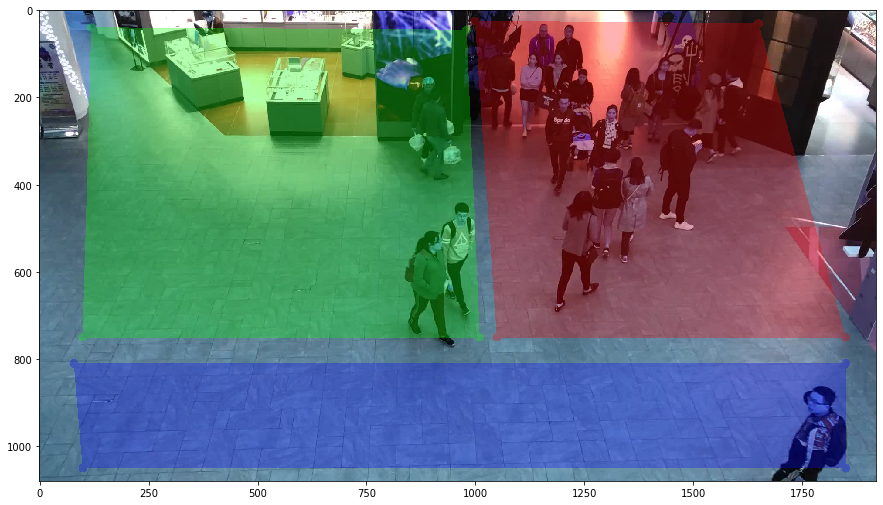

In [79]:
img = cv2.imread(EXAMPLE_IMAGE_JPG)

for point in zone_one:
    cv2.circle(img, point, 10, (255, 0, 0), -1)

for point in zone_two:
    cv2.circle(img, point, 10, (0, 255, 0), -1)

for point in zone_three:
    cv2.circle(img, point, 10, (0, 0, 255), -1)

# add colors to the zones
active = 0
for zone in zones:
    colors = [0, 0, 0]
    colors[active] = 255
    img = fill_zone(img, zone, colors)
    active += 1

img = blend_images(cv2.imread(EXAMPLE_IMAGE_JPG), img, 0.3)
show_image(img)

In the picture above we see the zones. Now lets extract the separate images from them.

In [86]:
zone_one_img = extract_zone_image(cv2.imread(EXAMPLE_IMAGE_JPG), zone_one)
zone_two_img = extract_zone_image(cv2.imread(EXAMPLE_IMAGE_JPG), zone_two)
zone_three_img = extract_zone_image(cv2.imread(EXAMPLE_IMAGE_JPG), zone_three)

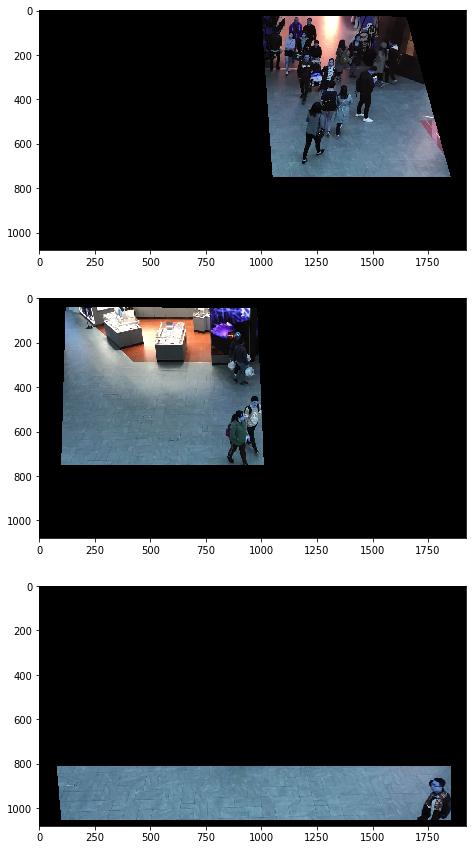

In [96]:
fig, axs = plt.subplots(3, figsize=(40, 15))
axs[0].imshow(zone_one_img)
axs[1].imshow(zone_two_img)
axs[2].imshow(zone_three_img)

The above picture shows how the images are going to be fed to the model.